<span style="font-family:Papyrus; font-size:3em;" >Estimating Parameter Confidence Intervals With Bootstrapping</span>

This notebook demonstrates the calculations required to do confidence interval constructions.
1. Construct a good model. This means checking that we get good $R^2$ values (or other model quality metrics) for each fold in a cross validation.
1. Compute residuals for the good model.
1. Construct a collection of parameter estimates. That is, for many repetitions
   1. Construct new observations (by using randomly selected residuals)
   1. Estimate parameter values
1. Construct the confidence interval

# Preliminaries

## Imports

In [1]:
%matplotlib inline
import numpy as np
import lmfit   # Fitting lib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
try:
    import tellurium as te
except:
    !pip install tellurium
    import tellurium as te
try:
    import SBstoat
except:
    !pip install SBstoat
from SBstoat.modelFitter import ModelFitter
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomizedResiduals, ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries

## Constants

In [2]:
TIME = "time"

# Model and Data

In [3]:
# Model used in this example
MODEL = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
PARAMETERS_TO_FIT = ["k1", "k2"]

In [4]:
# Globals
NUM_POINT = 30
SIM_TIME= 30
NOISE_STD = 0.3

In [5]:
rr = te.loada(MODEL)
fittedData = rr.simulate(0, SIM_TIME, NUM_POINT)
fittedTS = NamedTimeseries(namedArray=fittedData)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NOISE_STD)
OBS_TS = synthesizer.calculate()
OBS_TS

                  A         B         C
time                                   
0.000000   4.868550 -0.428328 -0.415006
1.034483   4.190362  0.009587  0.209413
2.068966   3.584250  0.985514 -0.497407
3.103448   3.933760  0.970888  1.154624
4.137931   3.235357  0.978467  0.655516
5.172414   3.115288  1.047640  0.733384
6.206897   2.338102  0.990259  1.179503
7.241379   2.717891  0.800329  1.125861
8.275862   2.762997  1.876287  1.694927
9.310345   1.714410  1.317236  1.919978
10.344828  1.707282  1.054592  2.270499
11.379310  2.070734  1.006258  3.097732
12.413793  2.071970  0.883794  1.698859
13.448276  1.359836  0.863108  3.478951
14.482759  0.736717  0.758204  2.849178
15.517241  1.509430  0.836820  3.133427
16.551724  1.036936  0.970456  3.693582
17.586207  1.027242  0.967630  2.915263
18.620690  0.568375  0.183015  3.467004
19.655172  0.537970  1.415971  3.433362
20.689655  0.233748  0.441643  3.668992
21.724138  1.012224  0.815747  4.123074
22.758621  0.374365  0.378975  4.193787


In [6]:
def plotData(observedTS):
    """
    Creates a scatter plot of the observed data.
    
    Parameters
    ----------
    observedTS: NamedTimeseries
    
    Returns
    -------
    
    """
    figure, ax = plt.subplots(1)
    for column in observedTS.colnames:
        _ = ax.scatter(observedTS[TIME], observedTS[column])
    _ = plt.legend(observedTS.colnames)
    return figure
        
# Tests
figure = plotData(OBS_TS)
assert(isinstance(figure, matplotlib.figure.Figure))
_ = figure.clear()

<Figure size 432x288 with 0 Axes>

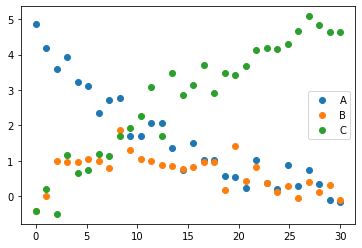

In [7]:
_ = plotData(OBS_TS)

# Bootstrapping Workflow

## Construct a good model.

First, we need to estimate the parameter values to use in our model. To this end, we do a fit on the full set of data.

In [8]:
FITTER = ModelFitter(MODEL, OBS_TS, parametersToFit=["k1", "k2"])
FITTER.fitModel()
FITTED_TS = FITTER.fittedTS
PARAMETER_ESTIMATES = FITTER.params
PARAMETER_ESTIMATES

name,value,initial value,min,max,vary
k1,0.09952752,5.0,-1.0000e-03,10.0000000,True
k2,0.21551891,5.0,-1.0000e-03,10.0000000,True


In [9]:
print(FITTER.reportFit())

[[Variables]]
    k1:  0.09952751571302786
    k2:  0.2155189128390689
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 90
    # variables        = 2
    chi-square         = 10.7120094
    reduced chi-square = 0.12172738
    Akaike info crit   = -187.559977
    Bayesian info crit = -182.560358
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.406


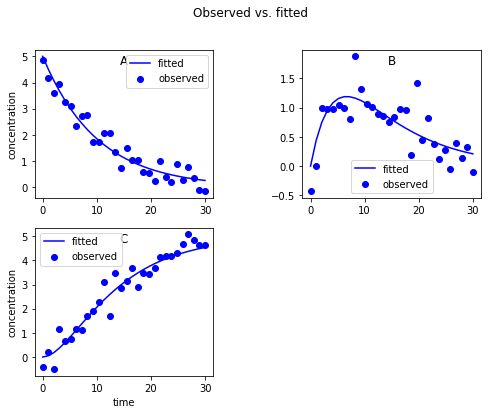

In [10]:
FITTER.plotFitAll()

**Question**
1. What are the parameter estimates if the NOSE_STD is 0.8?

## Compute the Residuals
Residuals need to be calculated by chemical species since they may be in very different units.

In [11]:
# Note that the residuals for the chemical species differ. Compare the residuals for A (1st col) with
# the residuals for C (3rd col)
columns = FITTED_TS.colnames
RESIDUALS_TS = OBS_TS.copy()  # Create the shape of the residuals
RESIDUALS_TS[columns] -= FITTED_TS[columns]
RESIDUALS_TS

                  A         B         C
time                                   
0.000000  -0.131450 -0.428328 -0.415006
1.034483  -0.320455 -0.428063  0.157880
2.068966  -0.485245  0.240494 -0.682893
3.103448   0.262410  0.018555  0.778307
4.137931  -0.076801 -0.104900  0.051040
5.172414   0.127180 -0.109132 -0.121735
6.206897  -0.357660 -0.196882  0.062407
7.241379   0.285873 -0.385526 -0.256266
8.275862   0.568918  0.714547  0.050745
9.310345  -0.265008  0.195619  0.021013
10.344828 -0.078476 -0.016132  0.126982
11.379310  0.459689 -0.006794  0.721830
12.413793  0.618543 -0.067817 -0.896102
13.448276  0.048607 -0.025546  0.678834
14.482759 -0.446226 -0.067628 -0.142047
15.517241  0.442222  0.072485 -0.035029
16.551724  0.074140  0.265457  0.361377
17.586207  0.158643  0.319249 -0.567756
18.620690 -0.215243 -0.411818 -0.154544
19.655172 -0.168982  0.871423 -0.315138
20.689655 -0.404039 -0.055959 -0.195620
21.724138  0.436836  0.361763  0.152446
22.758621 -0.144728 -0.034646  0.126502


In [12]:
# The standard deviation of the residuals should be approximately the same as the standard deviation
# of the random noise we injected in the construction of the observations.
np.std(RESIDUALS_TS.flatten())

0.3447038082421376

A validation of our codes and workflow is that the standard deviation of the residuals is close to the standard deviation of the noise used in the observational data.

## Construct a Collection of Parameter Estimates

### Step 3a: Construct Synthetic Observations
We define a function that constructs a set of observations from residuals and a model.

In [13]:
synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=FITTED_TS, 
                                                        observedTS=OBS_TS)

In [14]:
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   4.784757  0.195619  0.126982
1.034483   4.922160  0.314174 -0.516223
2.068966   4.331905  0.738226 -0.070781
3.103448   4.240268  0.917687 -0.191439
4.137931   2.902824  1.048721  0.482740
5.172414   2.894087  1.149978  0.981621
6.206897   2.375307  0.825240  1.274976
7.241379   2.353542  0.988972  1.403140
8.275862   2.352721  1.523503  1.329044
9.310345   1.885396  1.053800  1.949710
10.344828  1.465303  1.171496  2.249123
11.379310  1.479596  0.987506  2.384561
12.413793  1.527566  1.192106  2.440418
13.448276  1.095985  0.907209  2.875767
14.482759  0.804378  1.145081  3.053633
15.517241  0.746753  0.959954  3.026409
16.551724  0.642341  1.419545  3.353218
17.586207  0.790123  0.589048  3.843149
18.620690  0.706818  0.790452  3.773993
19.655172  0.992825  0.232191  3.799540
20.689655  0.233748  0.516157  3.885624
21.724138  0.861261  0.554756  3.287736
22.758621  0.350111  0.486105  3.752148


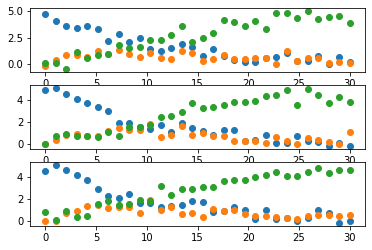

In [15]:
size = 3
fig, axes = plt.subplots(size)
for idx in range(size):
    ax = axes[idx]
    residualsTS = synthesizer.calculate()
    xvalues = residualsTS["time"]
    for col in residualsTS.colnames:
        ax.scatter(xvalues, residualsTS[col])

### Repeatedly estimate parameter values

In [16]:
def estimateParameters(model, observedTS, parametersToFit, numIteration=10):
    estimateDct = {p: [] for p in parametersToFit}
    # Get the initial estimates
    fitter = ModelFitter(model, observedTS, parametersToFit=parametersToFit)
    fitter.fitModel()
    initialParams = fitter.params
    # Create the observation synthesizer
    synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=fitter.fittedTS, observedTS=observedTS)
    # Iterative calculate parameters
    for _ in range(numIteration):
        newObservedTS = synthesizer.calculate()
        newFitter = ModelFitter(model, newObservedTS, parametersToFit=parametersToFit)
        newFitter.fitModel(params=initialParams)
        [estimateDct[p].append(newFitter.params.valuesdict()[p]) for p in parametersToFit]
    return estimateDct

# Tests
numIteration = 5
estimateDct = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=numIteration)
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == len(estimateDct[PARAMETERS_TO_FIT[1]]))
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == numIteration)

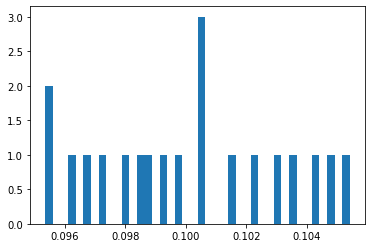

In [17]:
numIteration = 20
estimateDct = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=numIteration)
_ = plt.hist(estimateDct["k1"],bins=40)

**Questions**
1. How do the quality of the parameter estimates change with the number of simulation points? With the simulation time?

## Compute Confidence Intervals

In [18]:
np.quantile(range(10), [.10, .90])

array([0.9, 8.1])

**Question**
1. Calculate 95% confidence intervals for the parameters.
   1. How many iterations should you use?

### Solution

In [19]:
# Solution
for parameter in estimateDct.keys():
    quantile = np.quantile(estimateDct[parameter], [0.025, 0.975])
    print("%s: %s" % (parameter, str(quantile)))

k1: [0.09540149 0.10511288]
k2: [0.20163026 0.25672897]


**Questions**
1. Why does ``k1`` have such a wide confidence interval?

# Exercise

TRUE MODEL:

- A -> B
- A -> C
- B + C -> D

All kinetics are mass action. The kinetics constants are (in order of the reactions): 0.5, 0.5, 1.0. The initial concentration of A is 5. Consider a time course of duration 30 with 20 points.


1. Generate synthetic observations using this model using a normally distributed noise with a standard deviation
of 0.1.
1. Using the true model (the one above), find the $R^2$ values in a cross validation with 4 folds.
1. Construct confidence intervals for the parameters.

In [20]:
# Model used in this example
NEW_MODEL = """
     $A -> B; k1*$A
     $A -> C; k2*$A
     C -> D; k3*C
     D + B -> $E; k4*D*B
     
     A = 5;
     B = 10;
     C = 8;
     D = 4;
     E = 2
     k1 = 0.5
     k2 = 0.1
     k3 = 1.3;
     k4 = 1;
"""

In [21]:
# Solution: Constants
NEW_NUM_POINT = 100
NEW_END_TIME = 5
NEW_NOISE_STD = 0.4

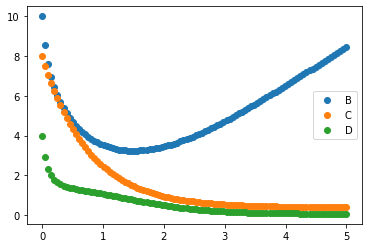

In [22]:
# Plot of the ground truth model
fittedTS = ModelFitter.runSimulation(modelSpecification=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=0.0)
_ = plotData(synthesizer.calculate())

We are going to estimate the parameters ``k1``, ``k2``, ``k3``, and the constant value of ``A``.

In [23]:
NEW_PARAMETERS_TO_FIT = ["k1", "k2", "k3", "A"]

## Generate randomized observations

**Question**
1. Generate data with 100 points over 30 s and a stardard deviation of 0.4.

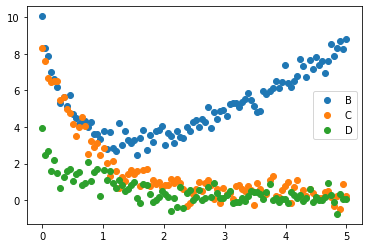

In [24]:
# Solution

fittedTS = ModelFitter.runSimulation(modelSpecification=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NEW_NOISE_STD)
NEW_OBS_TS = synthesizer.calculate()
_ = plotData(NEW_OBS_TS)

**Questions**
1. For what part of these data will it be difficult to estimate the dynamics and therefore the kinetics constants?

## Construct a good fit of the model
**Question**
1. Find a good fit for the model.
1. How good are the estimates relative to ground truth? If there are bad estimates, explain why.
1. Plot the model using the estimated values.

In [25]:
# Solution
NEW_FITTER = ModelFitter(NEW_MODEL, NEW_OBS_TS, parametersToFit=NEW_PARAMETERS_TO_FIT)
NEW_FITTER.fitModel()
NEW_FITTED_TS = NEW_FITTER.fittedTS
NEW_PARAMETER_ESTIMATES = NEW_FITTER.params
print(NEW_FITTER.reportFit())

[[Variables]]
    k1:  3.2437376097875172
    k2:  0.5775451650336212
    k3:  1.2889817505988663
    A:  0.7594564333510013
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 300
    # variables        = 4
    chi-square         = 46.1917195
    reduced chi-square = 0.15605311
    Akaike info crit   = -553.294577
    Bayesian info crit = -538.479447
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, A)  = -1.000
    C(k1, k2) =  1.000
    C(k2, A)  = -1.000
    C(k2, k3) =  0.306
    C(k1, k3) =  0.303
    C(k3, A)  = -0.303


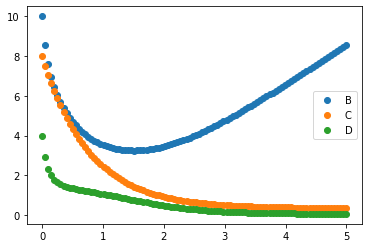

In [26]:
fittedTS = ModelFitter.runSimulation(modelSpecification=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     parameters=NEW_PARAMETER_ESTIMATES)
_ = plotData(fittedTS)

## Estimate the residuals

## Construct bootstrap estimates

In [27]:
NEW_FITTER = ModelFitter(NEW_MODEL, NEW_OBS_TS, parametersToFit=NEW_PARAMETERS_TO_FIT)
NEW_FITTER.fitModel()
NEW_FITTER.bootstrap(numIteration=1000)
print(NEW_FITTER.reportBootstrap())

iteration:  33%|███▎      | 329/1000 [01:58<03:52,  2.89it/s]




130.642882: 
 **
Curent value: 10.000000


ValueError: Must use bootstrap first.

In [ ]:
NEW_FITTER.bootstrapResult
